2025-06-12 18:08:37,276 - INFO - Using device: cpu
2025-06-12 18:08:37,280 - INFO - Starting combined embedding model training with enhancements...
2025-06-12 18:08:37,285 - INFO - Loading iFeature_AAC embeddings...
2025-06-12 18:08:37,286 - INFO - Loading and extracting features for aac from ../data/embeddings/iFeature_AAC.csv...
2025-06-12 18:08:37,304 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-06-12 18:08:37,310 - INFO - iFeature_AAC dimensions: (1720, 20)
2025-06-12 18:08:37,313 - INFO - Loading Kidera_encoded embeddings...
2025-06-12 18:08:37,314 - INFO - Loading and extracting features for kidera from ../data/embeddings/Kidera_encoded.csv...
2025-06-12 18:08:37,323 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-06-12 18:08:37,324 - INFO - Kidera_encoded dimensions: (1720, 10)
2025-06-12 18:08:37,324 - INFO - Loading BLOSUM62_encoded embeddings...
2025-06-12 18:08:37,324 - INFO - Loading and extracting features for blosum from ../data/embeddings/BLO

Fitting 5 folds for each of 30 candidates, totalling 150 fits


2025-06-12 18:09:01,523 - INFO - Best SVM parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
2025-06-12 18:09:01,524 - INFO - Best SVM CV ROC AUC: 0.8754
2025-06-12 18:09:01,560 - INFO - 
--- SVM (Test) Results ---
2025-06-12 18:09:01,561 - INFO - Accuracy: 0.8256
2025-06-12 18:09:01,561 - INFO - F1-score: 0.8286
2025-06-12 18:09:01,561 - INFO - Precision: 0.8146
2025-06-12 18:09:01,561 - INFO - Recall: 0.8430
2025-06-12 18:09:01,561 - INFO - ROC AUC: 0.8984
2025-06-12 18:09:01,562 - INFO - Confusion Matrix:
[[139  33]
 [ 27 145]]
2025-06-12 18:09:01,562 - INFO - 
Training XGBoost with combined embeddings...


Fitting 5 folds for each of 48 candidates, totalling 240 fits


2025-06-12 18:09:04,299 - INFO - Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
2025-06-12 18:09:04,300 - INFO - Best XGBoost CV ROC AUC: 0.8722
2025-06-12 18:09:04,304 - INFO - 
--- XGBoost (Test) Results ---
2025-06-12 18:09:04,305 - INFO - Accuracy: 0.8343
2025-06-12 18:09:04,305 - INFO - F1-score: 0.8367
2025-06-12 18:09:04,305 - INFO - Precision: 0.8249
2025-06-12 18:09:04,305 - INFO - Recall: 0.8488
2025-06-12 18:09:04,306 - INFO - ROC AUC: 0.8919
2025-06-12 18:09:04,306 - INFO - Confusion Matrix:
[[141  31]
 [ 26 146]]
2025-06-12 18:09:04,306 - INFO - 
Creating stacking ensemble...
2025-06-12 18:09:04,306 - INFO - Fitting base model: SVC
2025-06-12 18:09:04,417 - INFO - Fitting base model: XGBClassifier
2025-06-12 18:09:04,513 - INFO - Fitting meta-model: LogisticRegression
2025-06-12 18:09:04,560 - INFO - 
--- Stacking Ensemble (Test) Results ---
2025-06-12 18:09:04,560 - INFO - Accuracy: 0.8285
20

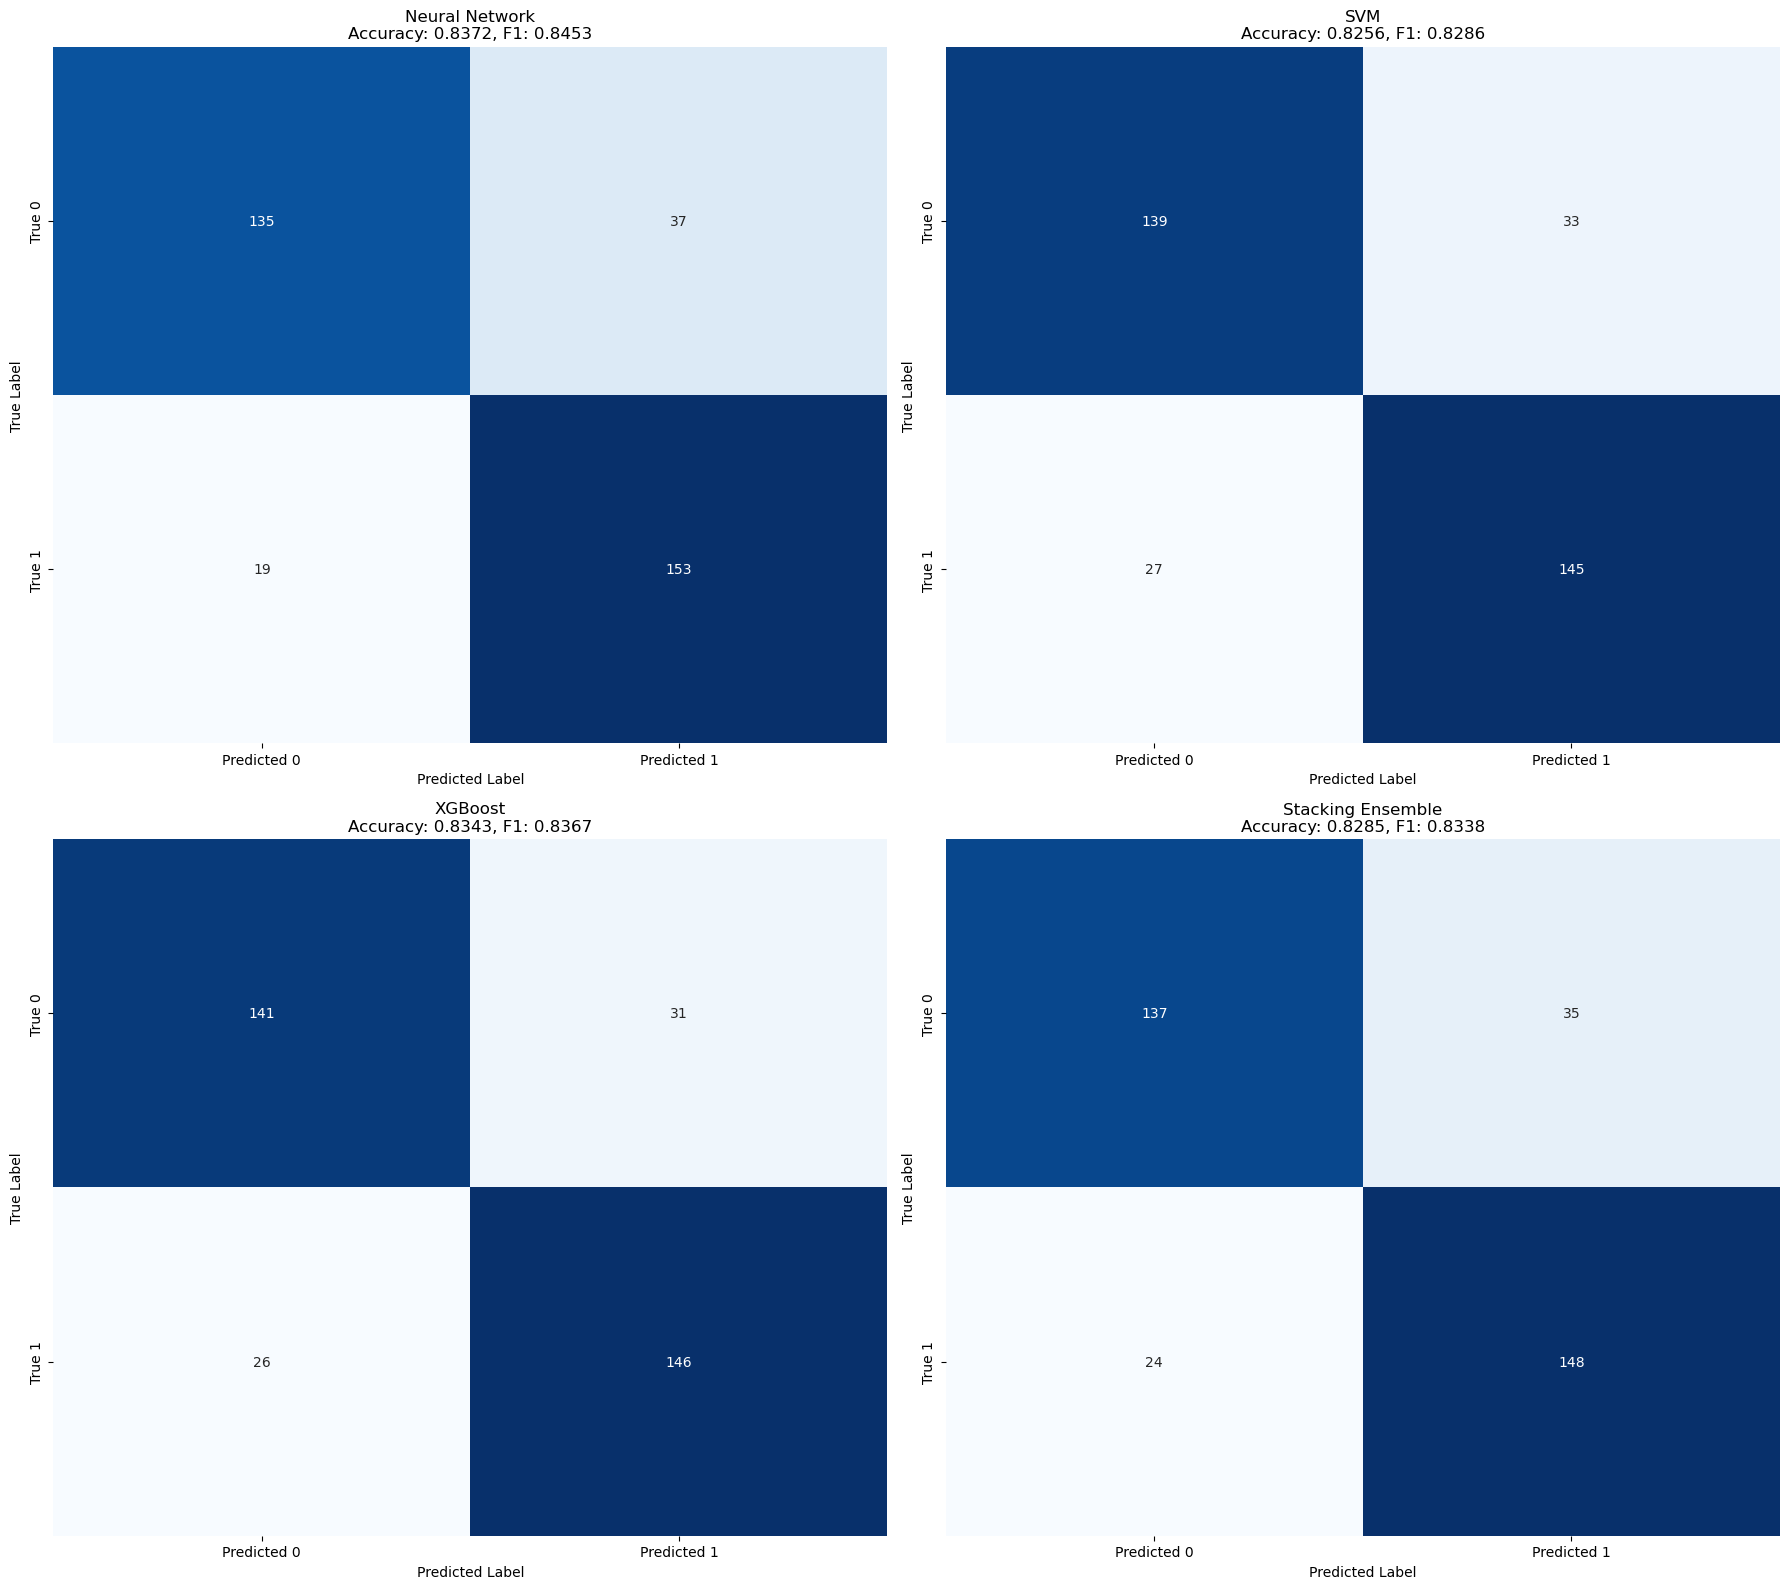

2025-06-12 18:09:05,177 - INFO - All models and artifacts saved to './combined_models'


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CyclicLR
import copy
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import os
from tqdm import tqdm
from scipy.special import softmax

# --- Configuration ---
# Defines various parameters for data loading, model training, and hyperparameter grids.
config = {
    'aac_data_path': '../data/embeddings/iFeature_AAC.csv',
    'kidera_data_path': '../data/embeddings/Kidera_encoded.csv',
    'blosum_data_path': '../data/embeddings/BLOSUM62_encoded.csv',
    'intensity_threshold': 207500,
    'test_size': 0.2,
    'val_size': 0.2, # This is the validation size for the NN, taken from the train_val split
    'random_state': 42,
    'batch_size': 64,
    'epochs': 200,
    'patience': 30, # Early stopping patience
    'early_stopping_delta': 1e-6, # Minimum change in loss to qualify as an improvement
    'learning_rate': 0.001, # Initial learning rate for AdamW
    'min_lr': 1e-6, # Minimum LR for CyclicLR
    'max_lr': 0.01, # Maximum LR for CyclicLR
    'weight_decay': 1e-4, # L2 regularization for AdamW
    'hidden_dims_nn': [512, 256, 128, 64, 32], # Hidden layer dimensions for the NN
    'dropout_rates_nn': [0.5, 0.4, 0.3, 0.2, 0.1], # Dropout rates for NN layers
    'gradient_clip_norm': 1.0, # Gradient clipping to prevent exploding gradients
    'noise_magnitude': 0.03, # Magnitude of Gaussian noise for data augmentation
    'feature_selection_ratio': 0.8, # Ratio of features to select using SelectKBest
    'label_smoothing': 0.1, # Not directly used in BCEWithLogitsLoss but can be added
    'mixup_alpha': 0.2, # Alpha parameter for Mixup augmentation
    'ema_decay': 0.999, # Exponential Moving Average decay for NN weights
    'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Device for PyTorch (GPU/CPU)
    'svm_param_grid': { # Hyperparameter grid for SVM GridSearchCV
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale'],
        'kernel': ['rbf']
    },
    'xgb_param_grid': { # Hyperparameter grid for XGBoost GridSearchCV
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'lr_scheduler_type': 'cyclic' # Type of learning rate scheduler for NN ('cyclic' or 'plateau')
}

# --- Seed Setting ---
def set_seed(seed: int) -> None:
    """
    Sets the random seed for reproducibility across numpy, random, and torch.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Initialize logging and device
set_seed(config['random_state'])
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device(config['device'])
logging.info(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
class FeatureDataset(Dataset):
    """
    Custom PyTorch Dataset for handling features and labels, with optional augmentation.
    """
    def __init__(self, features, labels, augment=False):
        self.features = features # Expects torch.Tensor features
        self.labels = labels     # Expects torch.Tensor labels
        self.augment = augment
        
    def __len__(self):
        """Returns the total number of samples."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.
        Applies augmentation if self.augment is True.
        """
        x = self.features[idx]
        y = self.labels[idx]
        
        if self.augment:
            # Add Gaussian noise to features
            noise = torch.randn_like(x) * config['noise_magnitude']
            x = x + noise
            
            # Mixup augmentation: blend with another random sample
            if random.random() > 0.5 and config['mixup_alpha'] > 0:
                lam = np.random.beta(config['mixup_alpha'], config['mixup_alpha'])
                rand_idx = random.randint(0, len(self.features)-1)
                x2 = self.features[rand_idx]
                y2 = self.labels[rand_idx]
                x = lam * x + (1 - lam) * x2
                y = lam * y + (1 - lam) * y2
                
        return x, y

def load_and_extract_features(data_path: str, intensity_threshold: int, embedding_type: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Loads a CSV file, extracts features, and creates a binary target variable
    based on an intensity threshold.
    """
    logging.info(f"Loading and extracting features for {embedding_type} from {data_path}...")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        logging.error(f"Error: Data file not found at {data_path}. Please check the path.")
        sys.exit(1) # Exit if file is not found
    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        sys.exit(1) # Exit on other CSV loading errors

    if df.empty:
        logging.error("Error: Loaded CSV file is empty. No data to process.")
        sys.exit(1) # Exit if DataFrame is empty

    # Feature column selection based on embedding type
    if embedding_type == 'aac':
        # AAC features are typically single-letter amino acid counts (A-Y, excluding B, J, O, U, X, Z)
        # Using a more robust check for columns that might represent AACs
        feature_columns = [col for col in df.columns if len(col) == 1 and 'A' <= col <= 'Z' and col not in ['B', 'J', 'O', 'U', 'X', 'Z']]
        if not feature_columns:
            logging.warning("No standard single-letter AAC columns found. Attempting to use all columns except 'Intensity'.")
            feature_columns = [col for col in df.columns if col != 'Intensity']
        X = df.loc[:, feature_columns].values.astype(np.float32)
    elif embedding_type == 'kidera':
        # Kidera factors are typically named KF1 to KF10
        X = df.loc[:, "KF1": "KF10"].values.astype(np.float32)
    elif embedding_type == 'blosum':
        # BLOSUM features typically start with 'BLOSUM62_'
        blosum_cols = [col for col in df.columns if col.startswith('BLOSUM62_')]
        X = df.loc[:, blosum_cols].values.astype(np.float32)
    else:
        logging.error(f"Unknown embedding_type: {embedding_type}. Supported types are 'aac', 'kidera', and 'blosum'.")
        sys.exit(1) # Exit on unknown embedding type

    if 'Intensity' not in df.columns:
        logging.error("Error: 'Intensity' column not found in the CSV. Required for target variable creation.")
        sys.exit(1) # Exit if 'Intensity' column is missing

    # Create binary target variable based on threshold
    y_class = (df['Intensity'] > intensity_threshold).astype(int).values
    class_counts = np.bincount(y_class)
    logging.info(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

    return X, y_class

def select_features(X_train, y_train, X_val, X_test, k_ratio=0.8):
    """
    Performs feature selection using SelectKBest with mutual_info_classif.
    Fits on training data and transforms training, validation, and test sets.
    """
    k = int(X_train.shape[1] * k_ratio) # Determine number of features to select
    if k == 0: # Ensure at least one feature is selected if k_ratio leads to 0
        k = 1
    elif k > X_train.shape[1]: # Do not select more features than available
        k = X_train.shape[1]

    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    logging.info(f"Selected {k} features using mutual information from {X_train.shape[1]} original features")
    return X_train_selected, X_val_selected, X_test_selected, selector

def create_and_scale_splits(X: np.ndarray, y: np.ndarray, test_size: float, val_size: float, random_state: int) -> tuple:
    """
    Splits the data into training, validation, and test sets, and scales them.
    The scaler is fitted only on the main training portion (X_train_val) to prevent data leakage.
    """
    # 1. Split into overall train_val and test sets first
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(sss_test.split(X, y))
    X_train_val_raw, X_test_raw = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # 2. Fit scaler ONLY on X_train_val_raw and transform all relevant sets
    scaler = StandardScaler()
    X_train_val_scaled = scaler.fit_transform(X_train_val_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    # 3. Split the ALREADY SCALED X_train_val_scaled into NN train and NN val sets
    # This ensures consistency in scaling for the NN
    sss_nn_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    # Use y_train_val for stratification, as X_train_val_scaled corresponds to it
    train_nn_idx, val_nn_idx = next(sss_nn_val.split(X_train_val_scaled, y_train_val))
    X_train_nn_scaled = X_train_val_scaled[train_nn_idx]
    X_val_nn_scaled = X_train_val_scaled[val_nn_idx]
    y_train_nn = y_train_val[train_nn_idx]
    y_val_nn = y_train_val[val_nn_idx]

    logging.info(f"NN Train dataset size: {len(X_train_nn_scaled)}")
    logging.info(f"NN Validation dataset size: {len(X_val_nn_scaled)}")
    logging.info(f"Final Test dataset size: {len(X_test_scaled)}")
    logging.info("Data scaled using StandardScaler (fitted on combined train+val data)")
    
    # Return all necessary splits and the scaler
    return (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
            X_test_scaled, y_test, scaler, X_train_val_scaled, y_train_val)


# --- Neural Network Architecture with Improvements ---
class ResidualBlock(nn.Module):
    """
    A Residual Block with two linear layers, BatchNorm, Dropout, and Swish activation.
    Includes a shortcut connection to facilitate training deeper networks.
    """
    def __init__(self, in_dim, out_dim, dropout_rate):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        # Shortcut connection: identity if dimensions match, else a linear projection
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        identity = self.shortcut(x) # Save input for shortcut connection
        out = self.linear1(x)
        out = self.bn1(out)
        out = F.silu(out)  # Swish activation (smoother than ReLU)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity # Add shortcut connection output
        return F.silu(out) # Final activation

class AttentionPooling(nn.Module):
    """
    Attention mechanism to weigh different features within a sample.
    It takes a feature vector (batch_size, feature_dim) and outputs a re-weighted
    feature vector of the same dimension, where weights are learned via an attention sub-network.
    """
    def __init__(self, feature_dim):
        super().__init__()
        # This sub-network computes attention scores for each feature.
        # It takes (batch_size, feature_dim) and outputs (batch_size, feature_dim) raw attention scores.
        self.attention_score_generator = nn.Sequential(
            nn.Linear(feature_dim, feature_dim), # Projects features to themselves
            nn.Tanh(),                           # Non-linearity
            nn.Linear(feature_dim, feature_dim)  # Outputs a score for each feature
        )
        
    def forward(self, x):
        # x is (batch_size, feature_dim), e.g., (64, 32)
        raw_attention_scores = self.attention_score_generator(x) # (batch_size, feature_dim)
        
        # Apply softmax across the feature dimension (dim=1) to get weights that sum to 1 for each sample
        attention_weights = F.softmax(raw_attention_scores, dim=1) # (batch_size, feature_dim)
        
        # Perform element-wise multiplication with the original features to apply attention
        # This produces a re-weighted feature vector of the same dimension.
        attended_features = x * attention_weights # (batch_size, feature_dim)
        
        return attended_features # Return (batch_size, feature_dim)


class ClassifierNN(nn.Module):
    """
    Neural Network Classifier with Residual Blocks and Attention Pooling.
    Also includes Exponential Moving Average (EMA) for model weights.
    """
    def __init__(self, input_dim: int, hidden_dims: list[int], dropout_rates: list[float]):
        super(ClassifierNN, self).__init__()
        layers = []
        
        # Initial projection layer to the first hidden dimension
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        
        # Stack Residual Blocks
        for i in range(len(hidden_dims)-1):
            layers.append(ResidualBlock(hidden_dims[i], hidden_dims[i+1], dropout_rates[i]))
        
        self.res_blocks = nn.Sequential(*layers) # Group residual blocks
        
        # Attention pooling layer
        self.attention = AttentionPooling(hidden_dims[-1])
        
        # Output layer for binary classification (single output, no activation)
        # This layer now correctly expects input of shape (batch_size, hidden_dims[-1])
        self.out = nn.Linear(hidden_dims[-1], 1)
        
        # EMA model for stable predictions during inference
        self.ema_model = copy.deepcopy(self)
        for param in self.ema_model.parameters():
            param.requires_grad = False # EMA model parameters should not be updated by gradient descent directly

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        x = F.silu(self.input_proj(x)) # Apply initial projection and activation
        x = self.res_blocks(x)         # Pass through residual blocks
        x = self.attention(x)          # Apply attention pooling, output is (batch_size, hidden_dims[-1])
        return self.out(x)             # Final output (logits)
    
    def update_ema(self, decay=0.999):
        """
        Updates the EMA model's weights using a decay factor.
        """
        with torch.no_grad(): # No gradient calculation needed for EMA update
            for param, ema_param in zip(self.parameters(), self.ema_model.parameters()):
                ema_param.data = decay * ema_param.data + (1 - decay) * param.data

# --- Early Stopping Helper Class ---
class EarlyStopping:
    """
    Monitors a validation metric and stops training when the metric
    does not improve for a certain number of epochs (patience).
    Also saves the best model weights.
    """
    def __init__(self, patience: int = 10, delta: float = 0.0):
        self.patience = patience
        self.delta = delta # Minimum change to qualify as an improvement
        self.best_loss = float('inf') # Initialize with infinity
        self.counter = 0 # Counter for epochs without improvement
        self.best_model_wts = None # To store best model weights
        self.early_stop = False # Flag for early stopping

    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        """
        Call method to update early stopping status based on current validation loss.
        """
        if val_loss < self.best_loss - self.delta: # If loss improves
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict()) # Save current model weights
            self.counter = 0 # Reset counter
        else: # If loss does not improve
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True # Trigger early stopping
        return self.early_stop

    def load_best_weights(self, model: nn.Module) -> None:
        """
        Loads the best saved model weights back into the model.
        """
        if self.best_model_wts:
            model.load_state_dict(self.best_model_wts)
            logging.info("Loaded best model weights based on validation loss.")
        else:
            logging.warning("No best model weights saved.")

# --- Learning Rate Finder (utility, not used in main execution by default) ---
def find_learning_rate(model, train_loader, criterion, optimizer, device, min_lr=1e-7, max_lr=1, num_iters=100):
    """
    Performs a learning rate range test to help find an optimal learning rate.
    Increases LR linearly and records loss.
    """
    model.train()
    lr_mult = (max_lr / min_lr) ** (1/num_iters) # Multiplicative factor for LR
    lr = min_lr
    optimizer.param_groups[0]['lr'] = lr # Set initial LR
    
    losses = []
    lrs = []
    
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= num_iters:
            break
            
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets.float())
        
        # Backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        # Update learning rate
        lr *= lr_mult
        optimizer.param_groups[0]['lr'] = lr
        
        # Track loss and learning rate
        losses.append(loss.item())
        lrs.append(lr)
        
    return lrs, losses

# --- Training and Evaluation Functions ---
def train_nn_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    early_stopper: EarlyStopping,
    epochs: int,
    device: torch.device,
    gradient_clip_norm: float
) -> nn.Module:
    """
    Trains the neural network model, including validation, scheduling, and early stopping.
    """
    logging.info(f"Starting Neural Network training for up to {epochs} epochs...")
    best_epoch = 0 # To record the epoch when the best model was saved
    
    for epoch in range(1, epochs + 1):
        model.train() # Set model to training mode
        current_train_loss = 0.0
        # Use tqdm for a progress bar during training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for xb, yb in progress_bar:
            xb, yb = xb.to(device), yb.to(device) # Move data to the specified device
            optimizer.zero_grad() # Clear previous gradients
            preds = model(xb).squeeze() # Forward pass
            loss = criterion(preds, yb.float()) # Calculate loss
            loss.backward() # Backpropagation
            
            # Apply gradient clipping if enabled
            if gradient_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_norm)
                
            optimizer.step() # Update model parameters
            model.update_ema(config['ema_decay']) # Update EMA model weights
            
            current_train_loss += loss.item() * xb.size(0) # Accumulate batch loss
            progress_bar.set_postfix(loss=loss.item()) # Update progress bar with current batch loss
            
        current_train_loss /= len(train_loader.dataset) # Average training loss

        # Validation phase
        model.eval() # Set model to evaluation mode
        current_val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation for validation
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze()
                loss = criterion(preds, yb.float())
                current_val_loss += loss.item() * xb.size(0)
        current_val_loss /= len(val_loader.dataset) # Average validation loss

        # Step learning rate scheduler
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(current_val_loss) # ReduceLROnPlateau steps based on a metric
        else:
            scheduler.step() # Other schedulers (like CyclicLR) step every epoch/iteration

        logging.info(f"  NN Epoch {epoch}/{epochs} - Train Loss: {current_train_loss:.4f}, Val Loss: {current_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Check for early stopping
        if early_stopper(current_val_loss, model):
            logging.info(f"  NN Early stopping triggered at epoch {epoch}. Restoring best model weights.")
            best_epoch = epoch
            break # Exit training loop
            
        if epoch == epochs: # If training completes all epochs
            best_epoch = epoch

    early_stopper.load_best_weights(model) # Load the best model weights before returning
    logging.info(f"Training completed. Best epoch: {best_epoch}")
    return model

def evaluate_classifier_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray = None, model_name: str = "Model") -> tuple:
    """
    Calculates and logs common classification metrics (accuracy, F1, precision, recall, ROC AUC, confusion matrix).
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    roc_auc = np.nan # Initialize ROC AUC to NaN
    if y_prob is not None and len(np.unique(y_true)) > 1: # ROC AUC requires probabilities and at least two classes
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except ValueError as e:
            logging.warning(f"Error computing ROC AUC for {model_name}: {e}") # Log if ROC AUC cannot be computed

    logging.info(f"\n--- {model_name} Results ---")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"F1-score: {f1:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"ROC AUC: {roc_auc:.4f}")
    logging.info(f"Confusion Matrix:\n{cm}")

    return accuracy, f1, precision, recall, roc_auc, cm

# --- Stacking Ensemble ---
class StackingEnsemble:
    """
    A stacking ensemble model that combines predictions from multiple base models
    using a meta-model (Logistic Regression in this case).
    """
    def __init__(self, base_models, meta_model):
        self.base_models = base_models # List of trained base models
        self.meta_model = meta_model   # The meta-model (e.g., Logistic Regression)
        
    def fit(self, X_base_train, y_train, X_base_val, y_val):
        """
        Fits the base models and then trains the meta-model on their predictions
        on the validation set.
        """
        # Train base models if they haven't been trained already.
        # Note: Neural Network is trained separately before this fit method is called.
        for model in self.base_models:
            if not isinstance(model, nn.Module): # Skip NN as it's trained externally
                logging.info(f"Fitting base model: {model.__class__.__name__}")
                model.fit(X_base_train, y_train)
        
        # Generate predictions from base models on the validation set for meta-model training
        base_preds_val = []
        for model in self.base_models:
            if isinstance(model, nn.Module):
                model.eval() # Set NN to eval mode
                # Ensure validation data is on the correct device for NN inference
                X_tensor = torch.tensor(X_base_val, dtype=torch.float32).to(device)
                with torch.no_grad():
                    # For NN, we get logits then apply sigmoid for probabilities
                    preds = torch.sigmoid(model(X_tensor).squeeze()).cpu().numpy()
                base_preds_val.append(preds)
            else:
                # For traditional models, use predict_proba to get probabilities
                base_preds_val.append(model.predict_proba(X_base_val)[:, 1])
        
        # Stack predictions column-wise to form the meta-feature set
        X_meta = np.column_stack(base_preds_val)
        
        # Train meta-model on the stacked predictions and actual validation labels
        logging.info(f"Fitting meta-model: {self.meta_model.__class__.__name__}")
        self.meta_model.fit(X_meta, y_val)
        return self
        
    def predict_proba(self, X_base_test):
        """
        Generates probability predictions from the stacking ensemble on new test data.
        """
        base_preds_test = []
        for model in self.base_models:
            if isinstance(model, nn.Module):
                model.eval() # Set NN to eval mode
                X_tensor = torch.tensor(X_base_test, dtype=torch.float32).to(device)
                with torch.no_grad():
                    # For NN, get logits then apply sigmoid for probabilities
                    preds = torch.sigmoid(model(X_tensor).squeeze()).cpu().numpy()
                base_preds_test.append(preds)
            else:
                # For traditional models, use predict_proba
                base_preds_test.append(model.predict_proba(X_base_test)[:, 1])
        
        # Stack test predictions
        X_meta_test = np.column_stack(base_preds_test)
        # Get final probabilities from the meta-model
        return self.meta_model.predict_proba(X_meta_test)
    
    def predict(self, X_base_test):
        """
        Generates binary class predictions from the stacking ensemble on new test data.
        """
        proba = self.predict_proba(X_base_test)
        # Convert probabilities to binary predictions (threshold 0.5)
        return (proba[:, 1] > 0.5).astype(int)

# --- Main Script Execution ---
def main():
    logging.info("Starting combined embedding model training with enhancements...")

    # Load and preprocess data from various embedding types
    logging.info("Loading iFeature_AAC embeddings...")
    X_aac, y_class_aac = load_and_extract_features(config['aac_data_path'], config['intensity_threshold'], 'aac')
    logging.info(f"iFeature_AAC dimensions: {X_aac.shape}")

    logging.info("Loading Kidera_encoded embeddings...")
    X_kidera, y_class_kidera = load_and_extract_features(config['kidera_data_path'], config['intensity_threshold'], 'kidera')
    logging.info(f"Kidera_encoded dimensions: {X_kidera.shape}")

    logging.info("Loading BLOSUM62_encoded embeddings...")
    X_blosum, y_class_blosum = load_and_extract_features(config['blosum_data_path'], config['intensity_threshold'], 'blosum')
    logging.info(f"BLOSUM62_encoded dimensions: {X_blosum.shape}")

    # Verify target consistency across different embedding files
    if not (np.array_equal(y_class_aac, y_class_kidera) and np.array_equal(y_class_aac, y_class_blosum)):
        logging.error("Target variables from different embeddings are not identical. Check input data alignment.")
        sys.exit(1) # Exit if targets don't match
    y_class = y_class_aac # Use one of them as the definitive target

    # Combine features horizontally
    X_combined = np.hstack((X_aac, X_kidera, X_blosum))
    logging.info(f"Combined feature dimensions: {X_combined.shape}")

    # Create data splits and apply global scaling
    (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
     X_test_scaled, y_test, scaler_global, X_train_val_scaled, y_train_val) = \
        create_and_scale_splits(X_combined, y_class, config['test_size'], config['val_size'], config['random_state'])

    # Apply feature selection to the scaled data
    # The feature selector is fitted on X_train_nn_scaled and then transforms all sets
    X_train_nn_selected, X_val_nn_selected, X_test_selected, feature_selector = \
        select_features(X_train_nn_scaled, y_train_nn, X_val_nn_scaled, X_test_scaled, 
                        config['feature_selection_ratio'])
    
    # Transform the overall training+validation set (for SVM/XGBoost) using the fitted selector
    X_train_val_selected = feature_selector.transform(X_train_val_scaled)
    input_dim_selected = X_train_nn_selected.shape[1] # Actual input dimension for the NN

    # Prepare PyTorch datasets from the selected and scaled features
    tensor_X_train_nn = torch.tensor(X_train_nn_selected, dtype=torch.float32)
    tensor_y_train_nn = torch.tensor(y_train_nn, dtype=torch.float32)
    tensor_X_val_nn = torch.tensor(X_val_nn_selected, dtype=torch.float32)
    tensor_y_val_nn = torch.tensor(y_val_nn, dtype=torch.float32)
    tensor_X_test = torch.tensor(X_test_selected, dtype=torch.float32)
    tensor_y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets with augmentation for training data
    train_nn_ds = FeatureDataset(tensor_X_train_nn, tensor_y_train_nn, augment=True)
    val_nn_ds = TensorDataset(tensor_X_val_nn, tensor_y_val_nn)
    test_nn_ds = TensorDataset(tensor_X_test, tensor_y_test)

    # Create DataLoaders for batching and shuffling
    train_nn_loader = DataLoader(train_nn_ds, batch_size=config['batch_size'], shuffle=True)
    val_nn_loader = DataLoader(val_nn_ds, batch_size=config['batch_size'], shuffle=False)
    test_nn_loader = DataLoader(test_nn_ds, batch_size=config['batch_size'], shuffle=False)

    # Calculate class weights for neural network's BCEWithLogitsLoss to handle imbalance
    count_class_0 = np.sum(y_train_nn == 0)
    count_class_1 = np.sum(y_train_nn == 1)
    # Assign higher weight to the minority class
    pos_weight = count_class_0 / count_class_1 if count_class_1 > 0 else 1.0
    logging.info(f"Positive class weight for NN: {pos_weight:.4f}")

    # Initialize neural network model, loss function, and optimizer
    nn_model = ClassifierNN(input_dim_selected, config['hidden_dims_nn'], config['dropout_rates_nn']).to(device)
    nn_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    nn_optimizer = torch.optim.AdamW(nn_model.parameters(), lr=config['learning_rate'], 
                                     weight_decay=config['weight_decay'])

    # Select and initialize learning rate scheduler
    if config['lr_scheduler_type'] == 'cyclic':
        nn_scheduler = CyclicLR(nn_optimizer, base_lr=config['min_lr'], max_lr=config['max_lr'],
                                step_size_up=2000, cycle_momentum=False)
        logging.info("Using CyclicLR learning rate scheduler")
    else: # Default to ReduceLROnPlateau
        nn_scheduler = ReduceLROnPlateau(nn_optimizer, 'min', patience=config['patience']//2, 
                                         factor=0.5, verbose=True)
        logging.info("Using ReduceLROnPlateau learning rate scheduler")

    # Initialize early stopping
    nn_early_stopper = EarlyStopping(patience=config['patience'], delta=config['early_stopping_delta'])

    # Train the neural network model
    best_nn_model = train_nn_model(
        nn_model, train_nn_loader, val_nn_loader, nn_criterion,
        nn_optimizer, nn_scheduler, nn_early_stopper,
        config['epochs'], device, config['gradient_clip_norm']
    )

    # Evaluate the trained neural network on the test set
    best_nn_model.eval() # Set NN to evaluation mode for inference
    nn_test_probs_list = []
    with torch.no_grad(): # Disable gradient calculation
        for xb, _ in test_nn_loader:
            xb = xb.to(device)
            outputs = best_nn_model(xb).squeeze()
            nn_test_probs_list.extend(torch.sigmoid(outputs).cpu().numpy()) # Convert logits to probabilities
    nn_test_probs = np.array(nn_test_probs_list)
    nn_test_preds = (nn_test_probs > 0.5).astype(int) # Convert probabilities to binary predictions

    nn_acc, nn_f1, nn_prec, nn_rec, nn_roc_auc, nn_cm = evaluate_classifier_metrics(
        y_test, nn_test_preds, nn_test_probs, "Neural Network (Test)"
    )

    # Train Support Vector Machine (SVM)
    logging.info("\nTraining SVM with combined embeddings...")
    svm_model = SVC(probability=True, random_state=config['random_state'], 
                    class_weight='balanced') # 'balanced' handles class imbalance
    svm_param_grid = config['svm_param_grid']
    svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, # 5-fold cross-validation
                                  scoring='roc_auc', verbose=1, n_jobs=-1) # Use all available cores
    svm_grid_search.fit(X_train_val_selected, y_train_val) # Train on the main training+validation set
    best_svm_model = svm_grid_search.best_estimator_ # Get the best model from grid search
    logging.info(f"Best SVM parameters: {svm_grid_search.best_params_}")
    logging.info(f"Best SVM CV ROC AUC: {svm_grid_search.best_score_:.4f}")

    # Evaluate SVM on the test set
    svm_test_probs = best_svm_model.predict_proba(X_test_selected)[:, 1]
    svm_test_preds = best_svm_model.predict(X_test_selected)

    svm_acc, svm_f1, svm_prec, svm_rec, svm_roc_auc, svm_cm = evaluate_classifier_metrics(
        y_test, svm_test_preds, svm_test_probs, "SVM (Test)"
    )

    # Train XGBoost Classifier
    logging.info("\nTraining XGBoost with combined embeddings...")
    # Removed use_label_encoder as it's deprecated and no longer needed.
    xgb_model = XGBClassifier(random_state=config['random_state'], eval_metric='logloss')
    xgb_grid_search = GridSearchCV(xgb_model, config['xgb_param_grid'], cv=5,
                                  scoring='roc_auc', verbose=1, n_jobs=-1)
    xgb_grid_search.fit(X_train_val_selected, y_train_val) # Train on the main training+validation set
    best_xgb_model = xgb_grid_search.best_estimator_
    logging.info(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
    logging.info(f"Best XGBoost CV ROC AUC: {xgb_grid_search.best_score_:.4f}")

    # Evaluate XGBoost on the test set
    xgb_test_probs = best_xgb_model.predict_proba(X_test_selected)[:, 1]
    xgb_test_preds = (xgb_test_probs > 0.5).astype(int)

    xgb_acc, xgb_f1, xgb_prec, xgb_rec, xgb_roc_auc, xgb_cm = evaluate_classifier_metrics(
        y_test, xgb_test_preds, xgb_test_probs, "XGBoost (Test)"
    )

    # Create and train the stacking ensemble
    logging.info("\nCreating stacking ensemble...")
    # Logistic Regression as the meta-model
    meta_model = LogisticRegression(max_iter=1000, random_state=config['random_state'])
    stacking_model = StackingEnsemble(
        [best_nn_model, best_svm_model, best_xgb_model], # Pass the best-trained base models
        meta_model
    )
    
    # Train stacking on predictions from the validation set (X_val_nn_selected)
    # The base models (SVM, XGBoost) were trained on X_train_val_selected.
    # The NN was trained on X_train_nn_selected and validated on X_val_nn_selected.
    # For stacking, the meta-model needs to learn to combine predictions on data it hasn't seen during base model training.
    # Therefore, X_train_nn_selected and X_val_nn_selected are used as the "base train" and "base val" for stacking.
    stacking_model.fit(X_train_nn_selected, y_train_nn, 
                       X_val_nn_selected, y_val_nn)

    # Evaluate the stacking ensemble on the test set
    stacking_test_preds = stacking_model.predict(X_test_selected)
    stacking_test_probs = stacking_model.predict_proba(X_test_selected)[:, 1]
    
    stack_acc, stack_f1, stack_prec, stack_rec, stack_roc_auc, stack_cm = evaluate_classifier_metrics(
        y_test, stacking_test_preds, stacking_test_probs, "Stacking Ensemble (Test)"
    )

    # Plot confusion matrices for all models
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    
    models = [
        ("Neural Network", nn_cm, nn_acc, nn_f1),
        ("SVM", svm_cm, svm_acc, svm_f1),
        ("XGBoost", xgb_cm, xgb_acc, xgb_f1),
        ("Stacking Ensemble", stack_cm, stack_acc, stack_f1)
    ]
    
    for i, (name, cm, acc, f1) in enumerate(models):
        row, col = i // 2, i % 2 # Arrange plots in a 2x2 grid
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['True 0', 'True 1'], ax=axes[row, col])
        axes[row, col].set_xlabel("Predicted Label")
        axes[row, col].set_ylabel("True Label")
        axes[row, col].set_title(f"{name}\nAccuracy: {acc:.4f}, F1: {f1:.4f}")
    
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plot_save_path = './images/confusion_matrices_combined.png'
    plt.savefig(plot_save_path) # Save the plot
    logging.info(f"Confusion matrices saved to '{plot_save_path}'")
    plt.show() # Display the plot

    # Save trained models and important artifacts
    models_dir = './combined_models'
    os.makedirs(models_dir, exist_ok=True) # Create directory if it doesn't exist
    
    torch.save(best_nn_model.state_dict(), os.path.join(models_dir, 'best_nn_model.pt'))
    joblib.dump(best_svm_model, os.path.join(models_dir, 'best_svm_model.pkl'))
    joblib.dump(best_xgb_model, os.path.join(models_dir, 'best_xgb_model.pkl'))
    joblib.dump(stacking_model, os.path.join(models_dir, 'stacking_ensemble.pkl'))
    joblib.dump(scaler_global, os.path.join(models_dir, 'scaler.pkl')) # Save the scaler
    joblib.dump(feature_selector, os.path.join(models_dir, 'feature_selector.pkl')) # Save the feature selector
    
    logging.info(f"All models and artifacts saved to '{models_dir}'")

if __name__ == "__main__":
    main()